## Synopisis: 
Spam emails account for nearly half of all emails recieved globally, with 54 billion spam emails sent per day. This project intends to build a classifier that can accurately determine emails that are spam from a random sampele.

### Author:
Kevin Liu

### Contact: 
kevinliu18@berkeley.edu

We begin by loading train and test data (emails) that have the following characteristics: ID, SUBJECT, EMAIL, and SPAM. 

In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [22]:
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

For ease of analysis, all characters will be converted to lowercase. This will be a limitation of our classifier, but will greatly reduce the character matching burden,

In [23]:
training_data['email'] = training_data['email'].str.lower()
test_data['email'] = test_data['email'].str.lower()

Our next step is to inspect the data and perform data cleaning. Our key indicator that something is wrong are NAN values so we will check that.

In [24]:
training_data[training_data['spam'].isnull()]

,id,subject,email,spam


In [25]:
training_data[training_data['subject'].isnull()]

,id,subject,email,spam
271,271,NaN,problem with spamtrap\n /home/yyyy/lib/spamtra...,0
1383,1383,NaN,problem with spamtrap\n /home/yyyy/lib/spamtra...,0
3605,3605,NaN,problem with spamtrap\n could not lock /home/y...,0
3658,3658,NaN,ripped from\n \n http://www.hpl.hp.com/persona...,0
3734,3734,NaN,problem with spamtrap\n /home/yyyy/lib/spamtra...,0
7221,7221,NaN,problem with spamtrap\n could not lock /home/y...,0


In [26]:
training_data[training_data['email'].isnull()]

,id,subject,email,spam


We see that the subject columns contain several NAN in the subject column. Manual inspection shows that thery are associated with a spamtrap. We will replace with subject NAN with an empty space.

In [27]:
training_data.fillna("", inplace = True)

Now that our data has been cleaned, we will now do a test-train split where the training data is split into seperate training and testing datasets. 

In [28]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(training_data, test_size=0.2)

Part of our spam classifer will be based on whether or not certain words is in the email. As such, we create a function that counts whether or not whether the email contains particular word(s) using a 1/0 one hot encoding scheme. We can also sum the result of the function to get a numericla representation of how many "spam words" are in the email.

In [29]:
def word_detector(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for i in texts:
        temp_array = []
        for j in words:
            if j in i:
                temp_array.append(1)
            else:
                temp_array.append(0)
        indicator_array.append(np.array(temp_array))
    return np.array(indicator_array)


We all know that spam emails may contain certain words in the body. As such, we will focus on analyzing the body of emails to determine if they are spam or not spam. Some certain words are plotted below, with a comparison between span and not spam emails.

[Text(0, 0, 'money'),
 Text(0, 0, 'guaranteed'),
 Text(0, 0, 'amazing'),
 Text(0, 0, 'exclusive'),
 Text(0, 0, 'gold'),
 Text(0, 0, 'check')]

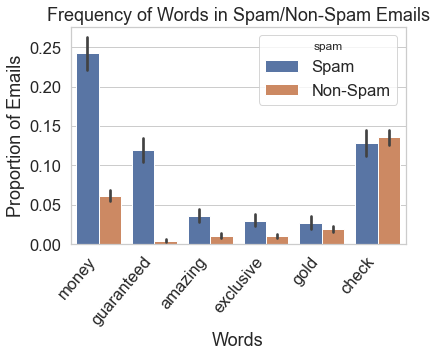

In [33]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
#Pick my 6 words, store in temp.
temp = train.copy()
temp["money"] = word_detector(["money"],temp["email"])
temp["guaranteed"] = word_detector(["guaranteed"],temp["email"])
temp["amazing"] = word_detector(["amazing"],temp["email"])
temp["exclusive"] = word_detector(["exclusive"],temp["email"])
temp["gold"] = word_detector(["gold"],temp["email"])
temp["check"] = word_detector(["check"],temp["email"])
temp = temp.drop(["id","subject","email"], axis = 1)
temp = temp.melt("spam")

temp['spam'] = temp['spam'].map({1:"Spam",0:"Non-Spam"})

#Plot bar chart.
plot = sns.barplot(data = temp, x = "variable", y = "value", hue = "spam")
plt.xlabel("Words")
plt.ylabel("Proportion of Emails")
plt.title("Frequency of Words in Spam/Non-Spam Emails")
plot.set_xticklabels(plot.get_xticklabels(), rotation=50, ha="right")


Spam emails and non-spam emails may also be asssociated with certain lengths. Here we we attempt to find a cutoff length that would indicate a spam email. Note that association does not imply causation, and is just one of the many factors we would consider.

<ipython-input-48-0b3b1f45ee60>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.axes()


(array([    0,  5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000,
        45000]),
 <a list of 10 Text major ticklabel objects>)

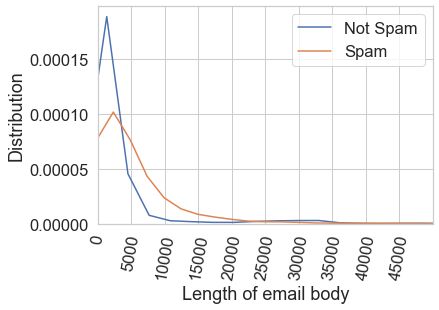

In [48]:
temp = train.copy()
temp["length"] = temp["email"].apply(lambda x: len(x))
sns.distplot(temp[temp["spam"] == 0]['length'],label = "Not Spam",hist = False)
sns.distplot(temp[temp["spam"] == 1]['length'],label = "Spam",hist = False)

plt.xlabel("Length of email body")
plt.ylabel("Distribution")
plt.xlim(0,50000)
axes = plt.axes()
axes.set_xticks(np.arange(0,50000,5000))
plt.xticks(rotation=80)


It appears that at spam emails decrease at a slower rate (length of email by characters) and is longer than spam emails (in general). 
In making a classifier, we now want to use a logistic regression model to determine the cutoff value (value determined by word_dectector function). 

In [18]:
spam_words = ['money', 'guaranteed', 'amazing', 'exclusive', 'gold','check']
X_train = word_detector(spam_words, train['email']) 
Y_train = train['spam'].values  
X_train[:5], Y_train[:5]
model = LogisticRegression().fit(X_train,Y_train)
training_accuracy = model.score(X_train,Y_train)
print("Training Accuracy: ", training_accuracy)



Training Accuracy:  0.787361485474693


/Users/kevinliu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


To increase the accuracy of the model, we can consider additional features. A heatmap can be used to see relevant features below.

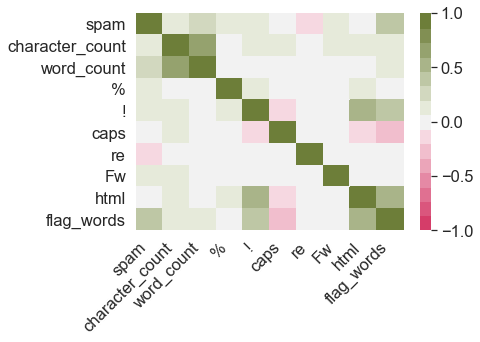

In [51]:
modify_train = train

# Containing number of character in subject line
modify_train['character_count'] = modify_train['subject'].str.len()

#Number of words in subject line
modify_train['word_count'] = modify_train['subject'].str.count(' ')

#Number of exclamation marks in email
modify_train['!'] = (modify_train['email'].str.findall(r'!').str.len())

#Number of dollar signs in email
modify_train['%'] = (modify_train['email'].str.findall(r'%').str.len())

#Percentage of caps in SUBJECT
modify_train['caps'] = (modify_train['subject'].str.findall(r'[A-Z]').str.len()) / (train['email'].str.len()) * 100

#Email is reply 
modify_train['re'] = modify_train['subject'].str.findall(r'RE:').str.len()

#Email is forward
modify_train['Fw'] = modify_train['subject'].str.findall(r'Fw:').str.len()

#Email html tag matching
modify_train["html"] = modify_train['email'].str.findall(r'<\s*a[^>]*>(.*?)<\s*/\s*a>').str.len()


#Redundant, only needed for heat map
special_words = ['money','guaranteed','html','special','free','gift','limited',
                 'credit','score','increase','personal','business','please','offer',
                 'wire','account','send','now','asking','full','backing','opportunity',
                 'clearance','order','now','extra','online','police','fbi','prince','earn',
                 'honorable','best','fast','deal','inheritance','lowest','loan',
                 'mortgage','personal']
 
modify_train['flag_words'] = word_detector(special_words,modify_train['email']).sum(axis = 1)
modify_train = modify_train.fillna(0)


corr =  modify_train[['spam','character_count','word_count','%','!',
                      'caps','re','Fw','html','flag_words']].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(0, 100, n=15),
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.show()

We see that many of the features only have a weak correlation, so a classifer must use a combination of these features to accurately determine of an email is spam or not spam. We will use all these features in a heatmap, along with a select list of words to determine if an email is spam or not spam. Our model will be a Logistic Regression model from SKlearn.

In [53]:
# Containing number of character in subject line
test['characters'] = test['subject'].str.len()

#Number of words in subject line
test['words'] = test['subject'].str.count(' ')

#Number of exclamation marks in email
test['!'] = (test['email'].str.findall(r'!').str.len())

#Number of dollar signs in email
test['%'] = (test['email'].str.findall(r'%').str.len())

#Percentage of caps in SUBJECT
test['caps'] = (test['subject'].str.findall(r'[A-Z]').str.len()) / (test['email'].str.len()) * 100

#Email is reply 
test['re'] = test['subject'].str.findall(r'RE:').str.len()

#Email is forward
test['Fw'] = test['subject'].str.findall(r'Fw:').str.len()

#Email html tag matching
test["html"] = test['email'].str.findall(r'<\s*a[^>]*>(.*?)<\s*/\s*a>').str.len()

test = test.fillna(0)


In [54]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV()


special_words = ['money','guaranteed','html','special','free','gift','limited',
                 'credit','score','increase','personal','business','please','offer',
                 'wire','account','send','now','asking','full','backing','opportunity',
                 'clearance','order','now','extra','online','police','fbi','prince','earn',
                 'honorable','best','fast','deal','inheritance','lowest','loan',
                 'mortgage','personal','debt','gold','investment','stock','eliminate',
                'lifetime','password','username','confirm','login','verify','friend',
                 'trial','sale','discount','insurance','weight','lose','loss','remove',
                'wrinkles','snoring','off','million','dollars','percent','member','freedom',
                'certificate','confidential','embassy','inspector','obligation','sell','buy',
                'priority','prize','terms','conditions','apply','warranty','waiting','won',
                'winner','grand','super','brillant','exciting','ad','hurry','delay','do not',
                'prince','crown','king','queen','inspector','seen','tv','virus','girls','gonna',
                'love','weekend','launched','last','chance','first','exclusive']
 

X_train = word_detector(special_words,modify_train['email'])
selected_features = modify_train[['character_count','word_count','!','%','caps','re','Fw','html']]
X_train = np.concatenate((X_train,selected_features),axis = 1)
Y_train = train['spam']

X_test = word_detector(special_words,test['email'])
selected_features_test = test[['characters','words','!','%','caps','re','Fw','html']]
X_test = np.concatenate((X_test,selected_features_test),axis = 1)

model.fit(X_train,Y_train)
test_predictions = model.predict(X_test)
model.score(X_train,Y_train)



/usr/local/Cellar/jupyterlab/2.1.4/libexec/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/Cellar/jupyterlab/2.1.4/libexec/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/usr/local/Cellar/jupyterlab/2.1.4/libexec/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/Cellar/jupyterlab/2.1.4/libexec/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/usr/local/Cellar/jupyterlab/2.1.4/libexec/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/Cellar/jupyterlab/2.1.4/libexec/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

0.927822701407607

## Conclusion:
We now see that our model is an accuracy of roughly 93% when including additional words and features such as email length, incidence of punctuation, and other factors. This an improvement of 7X% of our original logistic model of just using a list of words.